# Civil War prediction using econometrics


This is a replication of an Oxford econometric study from 2004 by Paul Collier and Anke Hoeffler *(Greed and grievance in civil war, Oxford Economic Papers 56, (2004), 563-595)*.  In the Jupyter Notebook I analyze the data, impute where deemed necessary, and use a class weighted **logistic regression** algorithm to predict the probability of a civil war breaking out in the following 5 year period, then analyze the most important coefficients.

Shalizi, Advanced Data Analysis: *Our data comes from a study of the causes of civil wars. Every row of the data represents a combination of a country and of a five year interval — the first row is Afghanistan, 1960, really meaning Afghanistan, 1960–1965. The variables are:*

* The country name;
* The year;
* An indicator for whether a civil war began during that period — the code of NA
means an on-going civil war, while 0 denotes continuing peace;
* Exports, really a measure of how dependent the country’s economy is on com-
modity exports;
* Secondary school enrollment rate for males, as a percentage;
* Annual growth rate in GDP;
* An index of the geographic concentration of the country’s population (which
would be 1 if the entire population lives in one city, and 0 if it evenly spread
across the territory);
* The number of months since the country’s last war or the end of World War
II, whichever is more recent;
* The natural logarithm of the country’s population;
* An index of social “fractionalization”, which tries to measure how much the
country is divided along ethnic and/or religious lines;
* An index of ethnic dominance, which tries to measure how much one ethnic
group runs affairs in the country.

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [116]:
df = pd.read_csv("ch.csv", index_col=0)

In [117]:
df

,country,year,start,exports,schooling,growth,peace,concentration,lnpop,fractionalization,dominance
1,Afghanistan,1960,0.0,0.074,2.0,NaN,172.0,0.492,16.119690,132.0,1.0
2,Afghanistan,1965,0.0,0.074,4.0,NaN,232.0,0.492,16.223810,132.0,1.0
3,Afghanistan,1970,0.0,0.043,13.0,NaN,292.0,0.492,16.337790,132.0,1.0
4,Afghanistan,1975,1.0,0.085,13.0,NaN,352.0,0.492,16.457279,132.0,1.0
5,Afghanistan,1980,NaN,0.240,16.0,NaN,NaN,0.492,16.584970,132.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
1284,Zimbabwe,1975,NaN,0.164,10.0,4.411,NaN,0.476,15.618040,3135.0,1.0
1285,Zimbabwe,1980,0.0,0.163,8.0,-2.241,1.0,0.476,15.762710,3245.0,1.0
1286,Zimbabwe,1985,0.0,0.146,50.0,0.165,61.0,0.476,15.934050,3245.0,1.0
1287,Zimbabwe,1990,0.0,0.147,53.0,-0.567,121.0,0.476,16.092470,3245.0,1.0


In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288 entries, 1 to 1288
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   country            1288 non-null   object 
 1   year               1288 non-null   int64  
 2   start              1167 non-null   float64
 3   exports            1163 non-null   float64
 4   schooling          1037 non-null   float64
 5   growth             918 non-null    float64
 6   peace              1167 non-null   float64
 7   concentration      1128 non-null   float64
 8   lnpop              1266 non-null   float64
 9   fractionalization  1160 non-null   float64
 10  dominance          1184 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 120.8+ KB


In [119]:
df.describe()

,year,start,exports,schooling,growth,peace,concentration,lnpop,fractionalization,dominance
count,1288.000000,1167.000000,1163.000000,1037.000000,918.000000,1167.000000,1128.000000,1266.000000,1160.000000,1184.000000
mean,1977.500000,0.066838,0.164038,42.651688,1.563059,326.595544,0.575080,15.354197,1783.729310,0.472973
std,11.460889,0.249848,0.184512,30.643082,3.777544,163.418574,0.221837,1.917788,1909.845065,0.499480
min,1960.000000,0.000000,0.002000,0.300000,-22.076000,1.000000,0.000000,10.621330,4.000000,0.000000
25%,1968.750000,0.000000,0.051500,16.000000,-0.313500,184.000000,0.467000,14.250530,171.000000,0.000000
50%,1977.500000,0.000000,0.109000,38.000000,1.874000,305.000000,0.583000,15.484630,936.000000,0.000000
75%,1986.250000,0.000000,0.203000,66.000000,3.722250,472.000000,0.750000,16.545258,3162.000000,1.000000
max,1995.000000,1.000000,2.139000,147.000000,14.409000,592.000000,0.971000,20.908350,6975.000000,1.000000


<AxesSubplot:title={'center':'Correlation heatmap'}>

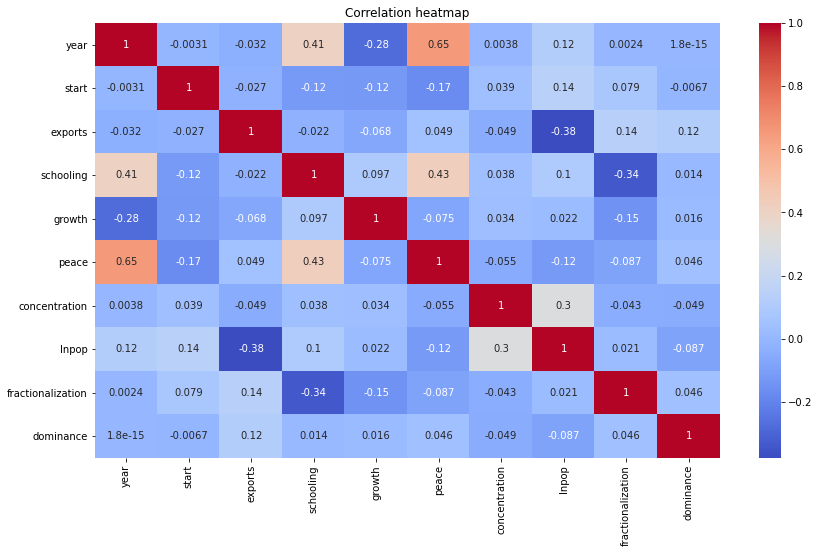

In [120]:
plt.figure(figsize=(14,8))
plt.title("Correlation heatmap")
sns.heatmap(df.corr(), annot=True, cmap="coolwarm")

In [121]:
df.isna().sum()

country                0
year                   0
start                121
exports              125
schooling            251
growth               370
peace                121
concentration        160
lnpop                 22
fractionalization    128
dominance            104
dtype: int64

**Perhaps understandably, schooling and growth data is missing from many countries where civil war has started in the given period.**

In [122]:
df[df['start']==1].isna().sum()

country               0
year                  0
start                 0
exports               6
schooling            12
growth               24
peace                 0
concentration         6
lnpop                 1
fractionalization     6
dominance             5
dtype: int64

In [123]:
df[df['country'] == 'Liberia']

,country,year,start,exports,schooling,growth,peace,concentration,lnpop,fractionalization,dominance
633,Liberia,1960,0.0,0.448,3.0,NaN,172.0,0.677,13.85377,4648.0,0.0
634,Liberia,1965,0.0,0.448,8.0,2.782,232.0,0.677,13.99366,4648.0,0.0
635,Liberia,1970,0.0,0.507,15.0,3.508,292.0,0.677,14.14121,4648.0,0.0
636,Liberia,1975,0.0,0.532,25.0,-0.747,352.0,0.677,14.29112,4814.0,0.0
637,Liberia,1980,0.0,0.516,31.0,-0.406,412.0,0.677,14.44625,4980.0,0.0
638,Liberia,1985,1.0,0.393,NaN,-1.664,472.0,0.677,14.60351,4980.0,0.0
639,Liberia,1990,1.0,0.331,NaN,NaN,1.0,0.677,14.70546,4980.0,0.0
640,Liberia,1995,NaN,0.331,NaN,NaN,NaN,0.686,14.82091,4980.0,0.0


In [124]:
df[df['country'] == 'Liberia']

,country,year,start,exports,schooling,growth,peace,concentration,lnpop,fractionalization,dominance
633,Liberia,1960,0.0,0.448,3.0,NaN,172.0,0.677,13.85377,4648.0,0.0
634,Liberia,1965,0.0,0.448,8.0,2.782,232.0,0.677,13.99366,4648.0,0.0
635,Liberia,1970,0.0,0.507,15.0,3.508,292.0,0.677,14.14121,4648.0,0.0
636,Liberia,1975,0.0,0.532,25.0,-0.747,352.0,0.677,14.29112,4814.0,0.0
637,Liberia,1980,0.0,0.516,31.0,-0.406,412.0,0.677,14.44625,4980.0,0.0
638,Liberia,1985,1.0,0.393,NaN,-1.664,472.0,0.677,14.60351,4980.0,0.0
639,Liberia,1990,1.0,0.331,NaN,NaN,1.0,0.677,14.70546,4980.0,0.0
640,Liberia,1995,NaN,0.331,NaN,NaN,NaN,0.686,14.82091,4980.0,0.0


We will interpolate the missing schooling and growth values, because we want to save as many true positives as we can, but we won't do more imputation.

In [125]:
df[['schooling', 'growth']] = df[['schooling', 'growth']].interpolate(method='linear', limit=3)

In [126]:
#Here we drop the missing values
df = df.dropna()

In [127]:
df[df['country'] == 'Liberia']

,country,year,start,exports,schooling,growth,peace,concentration,lnpop,fractionalization,dominance
633,Liberia,1960,0.0,0.448,3.00,3.06400,172.0,0.677,13.85377,4648.0,0.0
634,Liberia,1965,0.0,0.448,8.00,2.78200,232.0,0.677,13.99366,4648.0,0.0
635,Liberia,1970,0.0,0.507,15.00,3.50800,292.0,0.677,14.14121,4648.0,0.0
636,Liberia,1975,0.0,0.532,25.00,-0.74700,352.0,0.677,14.29112,4814.0,0.0
637,Liberia,1980,0.0,0.516,31.00,-0.40600,412.0,0.677,14.44625,4980.0,0.0
638,Liberia,1985,1.0,0.393,32.25,-1.66400,472.0,0.677,14.60351,4980.0,0.0
639,Liberia,1990,1.0,0.331,33.50,-0.85475,1.0,0.677,14.70546,4980.0,0.0


In [128]:
df.describe(include="all")

,country,year,start,exports,schooling,growth,peace,concentration,lnpop,fractionalization,dominance
count,882,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000,882.000000
unique,129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Ghana,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1977.346939,0.072562,0.158895,42.297398,1.497222,321.315193,0.601193,15.623405,1819.077098,0.444444
std,NaN,11.506393,0.259564,0.159198,30.626441,3.503718,164.881839,0.209298,1.680176,1975.857107,0.497186
min,NaN,1960.000000,0.000000,0.002000,1.000000,-15.264166,1.000000,0.000000,11.326600,12.000000,0.000000
25%,NaN,1965.000000,0.000000,0.055250,17.000000,-0.282250,172.000000,0.489250,14.640143,180.000000,0.000000
50%,NaN,1975.000000,0.000000,0.111000,36.000000,1.799500,292.000000,0.614000,15.635195,900.000000,0.000000
75%,NaN,1988.750000,0.000000,0.204750,64.000000,3.557000,472.000000,0.766000,16.589128,3375.000000,1.000000


Discard elements from the bigger class? Or bootstrap elements from the target class? (oversampling)

Or add a weighing factor? It could overfit. Or random perturbation (SMOTE)?

* https://en.wikipedia.org/wiki/Accuracy_paradox
* https://en.wikipedia.org/wiki/One_in_ten_rule

In [129]:
df['start'].value_counts()

0.0    818
1.0     64
Name: start, dtype: int64

In [130]:
rstate = 1768

**We set aside a final validation sample**

In [131]:
validation = df.sample(35, random_state=rstate)
validation

,country,year,start,exports,schooling,growth,peace,concentration,lnpop,fractionalization,dominance
669,Malaysia,1980,0.0,0.428,50.0,7.10600,268.0,0.766,16.437490,4488.0,0.0
1153,United Kingdom,1960,0.0,0.021,66.0,1.75350,172.0,0.699,17.773899,99.0,1.0
810,Norway,1965,0.0,0.100,66.0,4.28400,232.0,0.750,15.130040,16.0,0.0
330,El Salvador,1965,0.0,0.196,18.0,3.95500,232.0,0.434,14.918110,112.0,0.0
375,Gabon,1990,0.0,0.430,11.2,-0.56800,532.0,0.667,13.774690,3657.0,0.0
142,Botswana,1985,0.0,0.142,27.0,3.72400,472.0,0.705,13.887830,2703.0,1.0
269,Costa Rica,1980,0.0,0.140,44.0,2.32500,380.0,0.583,14.641440,144.0,0.0
305,Dominican Republic,1960,0.0,0.114,7.0,-0.57925,172.0,0.537,14.988300,90.0,0.0
336,El Salvador,1995,0.0,0.063,30.0,2.76100,35.0,0.446,15.549290,128.0,0.0
495,Iceland,1990,0.0,0.238,103.0,1.80500,532.0,0.935,12.448230,42.0,0.0


In [132]:
df = df.drop(validation.index)

In [133]:
fract = df['start'].value_counts(normalize=True)[1]

This would be the case when we upsample the target class, so the classes become more balanced. We decided not to use this however, since we only really care about probabilities, and we can set class weight in the logistic regression model.

In [134]:
upsample = df.sample(frac=(1-2*fract), weights='start', replace=True, random_state=rstate)

In [135]:
upsampled_df = pd.concat([df, upsample])
upsampled_df = upsampled_df.sample(frac=10, replace=True, random_state=rstate)


In [136]:
upsampled_df['start'].value_counts()

0.0    7868
1.0    7832
Name: start, dtype: int64

In [137]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [138]:
X = df.drop(['country', 'year', 'start'],axis=1)
y = df['start']

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=rstate)

In [140]:
scaler = StandardScaler()

In [141]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [142]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,plot_confusion_matrix, balanced_accuracy_score, roc_auc_score

In [143]:
log_model = LogisticRegression(solver='liblinear', class_weight={0: 0.1, 1: 0.9})

The cell below is a grid search for optimal class weights.

In [144]:
# #Setting the range for class weights
# weights = np.linspace(0.0,0.99,200)

# #Creating a dictionary grid for grid search
# param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

# #Fitting grid search to the train data with 5 folds
# gridsearch = GridSearchCV(estimator= log_model, 
#                           param_grid= param_grid,
#                           cv=StratifiedKFold(), 
#                           n_jobs=-1, 
#                           scoring='f1', 
#                           verbose=2).fit(scaled_X_train,y_train)

# #Ploting the score for different values of weight
# sns.set_style('whitegrid')
# plt.figure(figsize=(12,8))
# weigh_data = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
# sns.lineplot(weigh_data['weight'], weigh_data['score'])
# plt.xlabel('Weight for class 1')
# plt.ylabel('F1 score')
# plt.xticks([round(i/10,1) for i in range(0,11,1)])
# plt.title('Scoring for different class weights', fontsize=24)

In [145]:
log_model.get_params()

{'C': 1.0,
 'class_weight': {0: 0.1, 1: 0.9},
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [146]:
log_model.fit(scaled_X_train,y_train)

LogisticRegression(class_weight={0: 0.1, 1: 0.9}, solver='liblinear')

In [147]:
log_model.coef_

array([[ 0.14873683, -0.47699925, -0.27869072, -0.52161603, -0.11106131,
         0.70204515,  0.18143841,  0.21493114]])

In [148]:
y_pred = log_model.predict(scaled_X_test)

In [149]:
#y_pred = (log_model.predict_proba(scaled_X_test)[:,1] >= 0.5).astype(bool)

In [150]:
accuracy_score(y_test,y_pred)

0.8117647058823529

In [151]:
roc_auc_score(y_test,y_pred)

0.8062500000000001

In [152]:
balanced_accuracy_score(y_test,y_pred)

0.80625

In [153]:
confusion_matrix(y_test,y_pred)

array([[65, 15],
       [ 1,  4]])

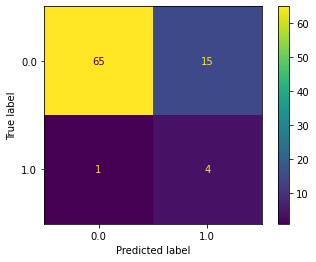

In [154]:
plot_confusion_matrix(log_model, scaled_X_test,y_test)

**We would like to have the least amount of false negatives (lower left), but our main concern for this analysis is the probabilities.**

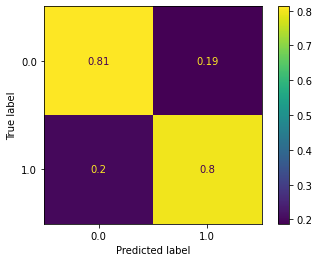

In [155]:
plot_confusion_matrix(log_model,scaled_X_test,y_test,normalize='true')

In [156]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.98      0.81      0.89        80
         1.0       0.21      0.80      0.33         5

    accuracy                           0.81        85
   macro avg       0.60      0.81      0.61        85
weighted avg       0.94      0.81      0.86        85



In [157]:
from sklearn.metrics import precision_recall_curve,plot_precision_recall_curve,plot_roc_curve

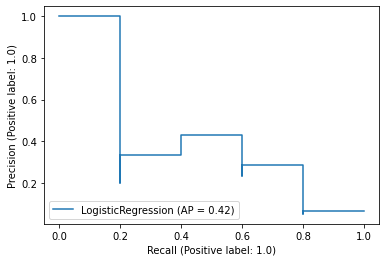

In [158]:
plot_precision_recall_curve(log_model,scaled_X_test,y_test)

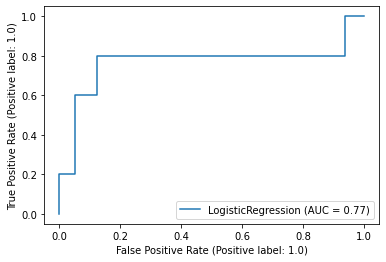

In [159]:
plot_roc_curve(log_model,scaled_X_test,y_test)

In [160]:
coefs = pd.Series(index=X.columns,data=log_model.coef_[0])

In [174]:
coefs = coefs.sort_values()
coefs

peace               -0.521616
schooling           -0.476999
growth              -0.278691
concentration       -0.111061
exports              0.148737
fractionalization    0.181438
dominance            0.214931
lnpop                0.702045
dtype: float64

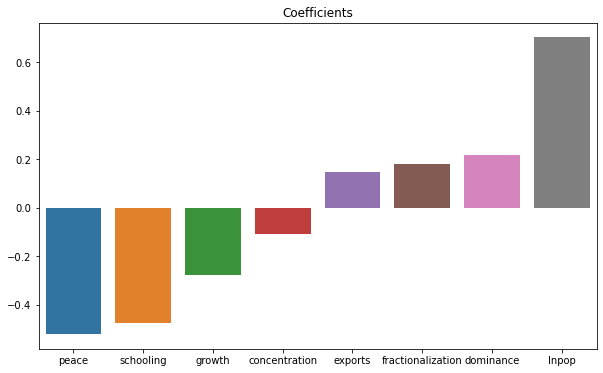

In [175]:
plt.figure(figsize=(10,6))
plt.title("Coefficients")
sns.barplot(x=coefs.index,y=coefs.values);

In [164]:
validation['probability'] = log_model.predict_proba(scaler.transform(validation.drop(['country', 'year', 'start'],axis=1)))[:,1]
validation['predicted_civil_war'] = log_model.predict(scaler.transform(validation.drop(['country', 'year', 'start', 'probability'],axis=1)))

In [165]:
validation['accuracy'] = np.where(validation["start"] == validation["predicted_civil_war"], True, False)


In [166]:
validation.sort_values(by='start', ascending=False)

,country,year,start,exports,schooling,growth,peace,concentration,lnpop,fractionalization,dominance,probability,predicted_civil_war,accuracy
428,Guatemala,1975,1.0,0.129,12.0,1.99700,30.0,0.636,15.611100,704.0,1.0,0.660145,1.0,True
23,Angola,1990,1.0,0.476,12.0,-2.35600,16.0,0.648,16.037861,3822.0,0.0,0.801605,1.0,True
1060,Sweden,1975,0.0,0.052,75.0,2.10000,352.0,0.732,15.918790,387.0,0.0,0.143736,0.0,True
792,Nicaragua,1995,0.0,0.210,43.0,2.23500,56.0,0.697,15.291420,198.0,1.0,0.487081,0.0,True
1079,Syria,1990,0.0,0.188,60.0,-1.68700,532.0,0.463,16.310040,440.0,1.0,0.278499,0.0,True
1158,United Kingdom,1985,0.0,0.072,82.0,2.00100,472.0,0.699,17.853020,99.0,1.0,0.265016,0.0,True
1142,Tunisia,1985,0.0,0.109,46.0,1.74900,367.0,0.638,15.798870,32.0,0.0,0.208332,0.0,True
929,Saudi Arabia,1960,0.0,0.609,4.0,0.13950,172.0,0.565,15.220380,12.0,0.0,0.577839,1.0,False
471,Honduras,1990,0.0,0.171,29.0,-0.14500,532.0,0.559,15.445730,144.0,0.0,0.186071,0.0,True
363,France,1970,0.0,0.031,71.0,4.61600,292.0,0.656,17.742861,864.0,1.0,0.381157,0.0,True


In [167]:
validation['probability'].mean()

0.34463674716056

In [168]:
validation['accuracy'].value_counts(normalize=True)

True     0.857143
False    0.142857
Name: accuracy, dtype: float64

Percentage true positives and false negatives of predicting a civil war:

In [169]:
validation[validation['start']==1]["accuracy"].value_counts(normalize=True)

True    1.0
Name: accuracy, dtype: float64

<AxesSubplot:xlabel='probability', ylabel='Count'>

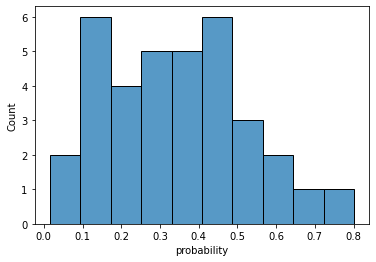

In [170]:
sns.histplot(data=validation, x='probability', bins=10)